In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-12-22 18:53:22.872322: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply

def create_model(input_shape=(64, 64, 15)):

    depths=[3, 3, 27, 3]
    projection_dims=[32, 64, 96, 128]
    drop_path_rate=0.0
    layer_scale_init_value=1e-6


    model_name='Branch64X'
    IN64 = layers.Input(shape=input_shape)
    X = IN64

    # X = layers.LocallyConnected2D(32, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc1_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc1_gelu".format(model_name))(X)

    # X = layers.LocallyConnected2D(96, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc2_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc2_gelu".format(model_name))(X)

    # ----- convnext block 0 ----- #

    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 3 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

    for j in range(depths[3]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                                   groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    V1 = X

    OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

    OUT = layers.Dense(64, name="{}_dense1".format(model_name))(OUT)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
    OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

    OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

    model = Model(inputs=IN64, outputs=OUT, name=model_name)

    return model

In [6]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [7]:
# from importlib import reload
# reload(ck)

In [8]:
#ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
L_vars = len(ind_pick_from_batch)

In [9]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*pos*.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*pos*.npy"))

print('neg:{} vs pos:{}'.format(len(filename_neg_train), len(filename_pos_train)))

neg:6739773 vs pos:27551


In [16]:
filename_valid = filename_neg_valid[::600] + filename_pos_valid[::5]
#filename_valid = filename_neg_valid[::200] + filename_pos_valid[::50]
print(len(filename_valid))

L_valid = len(filename_valid)

VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
VALID_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        VALID_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            VALID_target[i] = 1.0
        else:
            VALID_target[i] = 0.0

8519


**ConvNext**

In [11]:
#tf.config.list_physical_devices('GPU')

In [15]:
training_rounds = 20

seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695]

min_del = 0
max_tol = 1000 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 64 #int(len(TRAIN_Y_pick) / batch_size)

X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# =========== Model Section ========== #
key = 'RE0_15p_base'
model_name = '{}_copy2'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = 0.03321288125144548 #0.021237620777840503 #0.05669766786174394 #0.08634155630837792
print("Initial record: {}".format(record))

count = 0


for r in range(training_rounds):
    
    tol = 0 - count - r
    
    #flag_count_change = True
    
    model = create_model(input_shape=(64, 64, 15))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=1e-4))
    
    # W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_base_tune/')
    # model.set_weights(W_old)
    
    set_seeds(seeds[r+1])
    print('Training round {}'.format(r))
    
    for i in range(epochs):
    
        #backend.set_value(model.optimizer.learning_rate, learning_rate[i])
        
        #print('epoch = {}'.format(i))
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            
            N_pos = 20
            N_neg = batch_size - N_pos
            
            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)
        
            file_pick_neg = []
            for ind_temp in ind_neg[:N_neg]:
                file_pick_neg.append(filename_neg_train[ind_temp])

            file_pick_pos = []
            for ind_temp in ind_pos[:N_pos]:
                file_pick_pos.append(filename_pos_train[ind_temp])
        
            file_pick = file_pick_neg + file_pick_pos
            
            if len(file_pick) != batch_size:
                sregwet
        
            for k in range(batch_size):
                data = np.load(file_pick[k])
                
                for l, c in enumerate(ind_pick_from_batch):
                    temp = data[..., c] 
                    X_batch_64[k, ..., l] = temp
                    
                if 'pos' in file_pick[k]:
                    Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
                elif 'neg_neg_neg' in file_pick[k]:
                    Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
                else:
                    werhgaer
                    
            ind_ = du.shuffle_ind(batch_size)
            X_batch_64 = X_batch_64[ind_, ...]
            Y_batch = Y_batch[ind_, :]
            
            # train on batch
            model.train_on_batch(X_batch_64, Y_batch);
            
        # epoch end operations
        Y_pred = model.predict([VALID_input_64])
        # Y_pred[Y_pred<0] = 0
        # Y_pred[Y_pred>1] = 1
        
        Y_pred = 1/(1 + np.exp(-Y_pred))
        
        record_temp = verif_metric(VALID_target, Y_pred)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del) and np.max(Y_pred)>0.6:
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp >= 2.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    if tol == 1 and i > count:
                        #flag_count_change = False
                        count = i
                        print(count)
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 1.1
Training round 0
0.022179472205888666
Validation loss 0.022179472205888666 NOT improved
0.025275356328014108
Validation loss 0.025275356328014108 NOT improved
0.03633699446924586
Validation loss improved from 1.1 to 0.03633699446924586
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy2
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy2/assets
--- 439.66421270370483 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.048511766339551954
Validation loss 0.048511766339551954 NOT improved
3
0.05315178454834211
Validation loss 0.05315178454834211 NOT improved
0.04493516815408174
Validation loss 0.04493516815408174 NOT improved
0.03819475650254773
Validation loss 0.03819475650254773 NOT improved
0.041698090102860616
Validation loss 0.041698090102860616 NOT improved
0.05136886296260758
Validation loss 0.05136886296260758 NOT improved
0.044758147129162706
Validation loss 0.044758147129162706 NOT improved
0.040805373968599526
Validation loss 0.040805373968599526 NOT improved
0.04689684526682583
Validation loss 0.04689684526682583 NOT improved
0.05165384750385338
Validation loss 0.05165384750385338 NOT improved
0.055081148639997336
Validation loss 0.055081148639997336 NOT improved
0.0565270226222414
Validation loss 0.0565270226222414 NOT improved
0.05022105637478655
Validation loss 0.05022105637478655 NOT improved
0.04546460527677465
Validation loss 0.04546460527677465 NOT improved
0.04709897875616986
Vali

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.045834355150250944
Validation loss 0.045834355150250944 NOT improved
25
0.04073800056562714
Validation loss 0.04073800056562714 NOT improved
0.043877649365047226
Validation loss 0.043877649365047226 NOT improved
0.0524021503080471
Validation loss 0.0524021503080471 NOT improved
0.04781086611645874
Validation loss 0.04781086611645874 NOT improved
0.051972829832033336
Validation loss 0.051972829832033336 NOT improved
0.04627397840451986
Validation loss 0.04627397840451986 NOT improved
0.048852450797614036
Validation loss 0.048852450797614036 NOT improved
0.06293642189573502
Validation loss 0.06293642189573502 NOT improved
0.0393718550392178
Validation loss 0.0393718550392178 NOT improved
0.04514364421617872
Validation loss 0.04514364421617872 NOT improved
0.047351632203221576
Validation loss 0.047351632203221576 NOT improved
0.05972417799207884
Validation loss 0.05972417799207884 NOT improved
0.051343745074832456
Validation loss 0.051343745074832456 NOT improved
0.04554909279523507
Val

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04381106151452017
Validation loss 0.04381106151452017 NOT improved
104
0.03687707463038397
Validation loss 0.03687707463038397 NOT improved
0.04203580778746684
Validation loss 0.04203580778746684 NOT improved
0.03743552945802685
Validation loss 0.03743552945802685 NOT improved
0.03865404376788166
Validation loss 0.03865404376788166 NOT improved
0.03538632403992408
Validation loss 0.03538632403992408 NOT improved
0.047910514680421616
Validation loss 0.047910514680421616 NOT improved
0.04556902929481029
Validation loss 0.04556902929481029 NOT improved
0.03798101405606114
Validation loss 0.03798101405606114 NOT improved
0.047253108332244956
Validation loss 0.047253108332244956 NOT improved
0.04627616866107757
Validation loss 0.04627616866107757 NOT improved
0.04120129103983136
Validation loss 0.04120129103983136 NOT improved
0.04311758633186049
Validation loss 0.04311758633186049 NOT improved
0.03808884704512269
Validation loss 0.03808884704512269 NOT improved
0.034522606198354934
Valid


KeyboardInterrupt



In [17]:
model = create_model(input_shape=(64, 64, 15))

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy2/')
#W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/FAKE_Lead6_tune3')
model.set_weights(W_old)

In [18]:
Y_pred = model.predict([VALID_input_64])
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1

Y_pred = 1/(1 + np.exp(-Y_pred))

record_temp = verif_metric(VALID_target, Y_pred)

0.11523598272064081


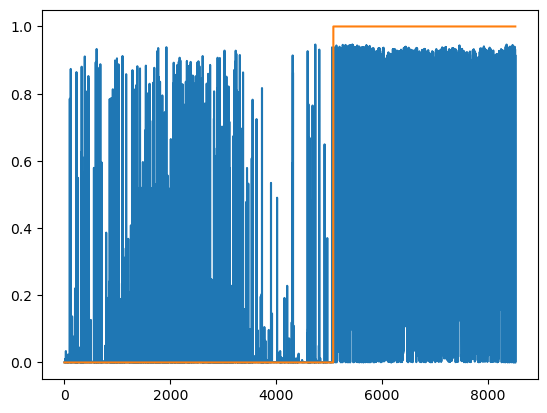

In [19]:
plt.plot(Y_pred)
plt.plot(VALID_target)

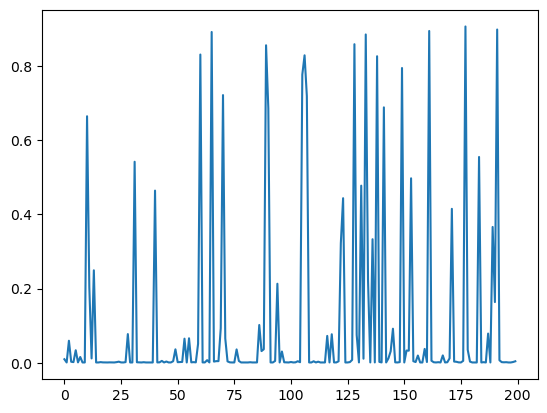

In [20]:
plt.plot(Y_pred[2000:2200])

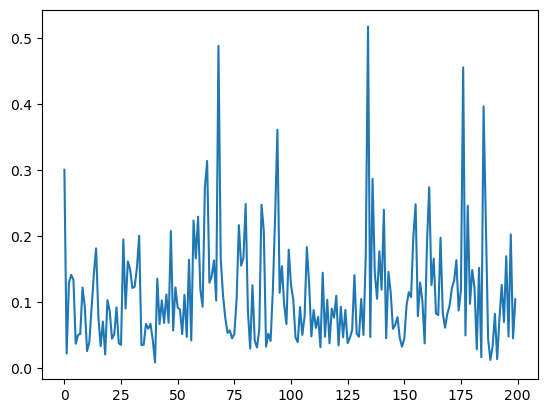

In [36]:
plt.plot(Y_pred[-200:])

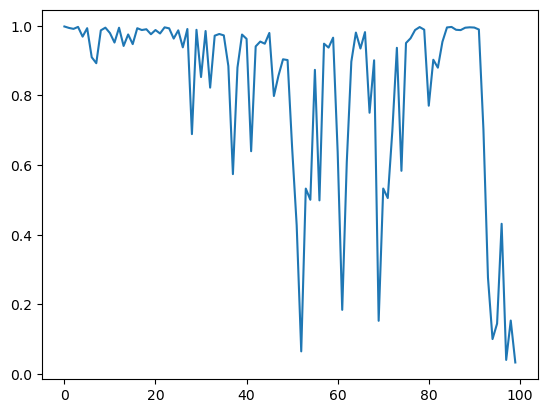

In [71]:
plt.plot(Y_pred[-100:])

In [31]:
Y_pred = model.predict([TESTv4_input_64])
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1

Y_pred = 1/(1 + np.exp(-Y_pred))

record_temp = verif_metric(TESTv4_target, Y_pred)

0.10501852837890428


In [32]:
record_temp

0.10501852837890428